### DA 420 - Project 2
### Matt Graham

#### Imports

In [1]:
# Traditional Conjoint Analysis (Python)

# prepare for Python version 3x features and functions
from __future__ import division, print_function

# import packages for analysis and modeling
import pandas as pd  # data frame operations
import numpy as np  # arrays and math functions
from numpy import unique
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
from patsy.contrasts import Sum
from scipy.stats import uniform  # for training-and-test split
import matplotlib.pyplot as plt  # 2D plotting
import seaborn as sns

#### Get an clean data

In [2]:


# read in Dodgers bobbleheads data and create data frame
dodgers = pd.read_csv("dodgers.csv")

# examine the structure of the data frame
# print("\nContents of dodgers data frame ---------------")

# attendance in thousands for plotting 
dodgers['attend_000'] = dodgers['attend']/1000

# print the first five rows of the data frame
# print(pd.DataFrame.head(dodgers)) 

mondays = dodgers[dodgers['day_of_week'] == 'Monday']
tuesdays = dodgers[dodgers['day_of_week'] == 'Tuesday']
wednesdays = dodgers[dodgers['day_of_week'] == 'Wednesday']
thursdays = dodgers[dodgers['day_of_week'] == 'Thursday']
fridays = dodgers[dodgers['day_of_week'] == 'Friday']
saturdays = dodgers[dodgers['day_of_week'] == 'Saturday']
sundays = dodgers[dodgers['day_of_week'] == 'Sunday']

# convert days' attendance into list of vectors for box plot
data = [mondays['attend_000'], tuesdays['attend_000'], 
    wednesdays['attend_000'], thursdays['attend_000'], 
    fridays['attend_000'], saturdays['attend_000'], 
    sundays['attend_000']]
ordered_day_names = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

april = dodgers[dodgers['month'] == 'APR']
may = dodgers[dodgers['month'] == 'MAY']
june = dodgers[dodgers['month'] == 'JUN']
july = dodgers[dodgers['month'] == 'JUL']
august = dodgers[dodgers['month'] == 'AUG']
september = dodgers[dodgers['month'] == 'SEP']
october = dodgers[dodgers['month'] == 'OCT']

data = [april['attend_000'], may['attend_000'], 
    june['attend_000'], july['attend_000'], 
    august['attend_000'], september['attend_000'], 
    october['attend_000']]
ordered_month_names = ['April', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct']

dodgers

,month,day,attend,day_of_week,opponent,temp,skies,day_night,cap,shirt,fireworks,bobblehead,attend_000
0,APR,10,56000,Tuesday,Pirates,67,Clear,Day,NO,NO,NO,NO,56.000
1,APR,11,29729,Wednesday,Pirates,58,Cloudy,Night,NO,NO,NO,NO,29.729
2,APR,12,28328,Thursday,Pirates,57,Cloudy,Night,NO,NO,NO,NO,28.328
3,APR,13,31601,Friday,Padres,54,Cloudy,Night,NO,NO,YES,NO,31.601
4,APR,14,46549,Saturday,Padres,57,Cloudy,Night,NO,NO,NO,NO,46.549
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,SEP,29,40724,Saturday,Rockies,84,Cloudy,Night,NO,NO,NO,NO,40.724
77,SEP,30,35607,Sunday,Rockies,95,Clear,Day,NO,NO,NO,NO,35.607
78,OCT,1,33624,Monday,Gians,86,Clear,Night,NO,NO,NO,NO,33.624
79,OCT,2,42473,Tuesday,Gians,83,Clear,Night,NO,NO,NO,NO,42.473


### Box plots and analysis

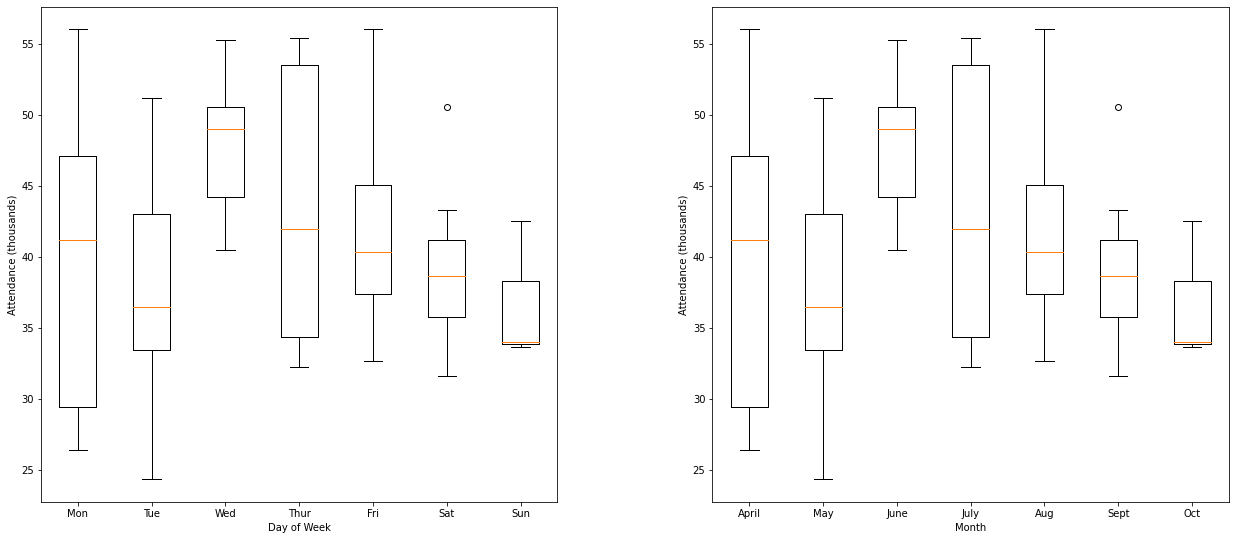

In [3]:
fig = plt.figure(figsize=(20,20))

set_I = fig.add_subplot(2, 2, 1)
set_I.set_xlabel('Day of Week')
set_I.set_ylabel('Attendance (thousands)')
day_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(day_plot['boxes'], color = 'black')    
plt.setp(day_plot['whiskers'], color = 'black')    
plt.setp(day_plot['fliers'], color = 'black', marker = 'o')
set_I.set_xticklabels(ordered_day_names)

set_II = fig.add_subplot(2, 2, 2)
set_II.set_xlabel('Month')
set_II.set_ylabel('Attendance (thousands)')
day_plot = plt.boxplot(data, sym='o', vert=1, whis=1.5)
plt.setp(day_plot['boxes'], color = 'black')    
plt.setp(day_plot['whiskers'], color = 'black')    
plt.setp(day_plot['fliers'], color = 'black', marker = 'o')
set_II.set_xticklabels(ordered_month_names)

plt.subplots_adjust(left=0.1, right=0.925, top=0.925, bottom=0.1, 
    wspace = 0.3, hspace = 0.4)

#### Analysis

We an see that Saturday's are an outlier, and so is September. This appears to maybe be the same value as the attendance in thousands is equal on both occassions. Otherwise, spread across most months and days are consistent; some being wide, such as early in the week and year, respectively. This can be due to seasonality!

### Scatter plots and analysis

#### Weather attedance analysis

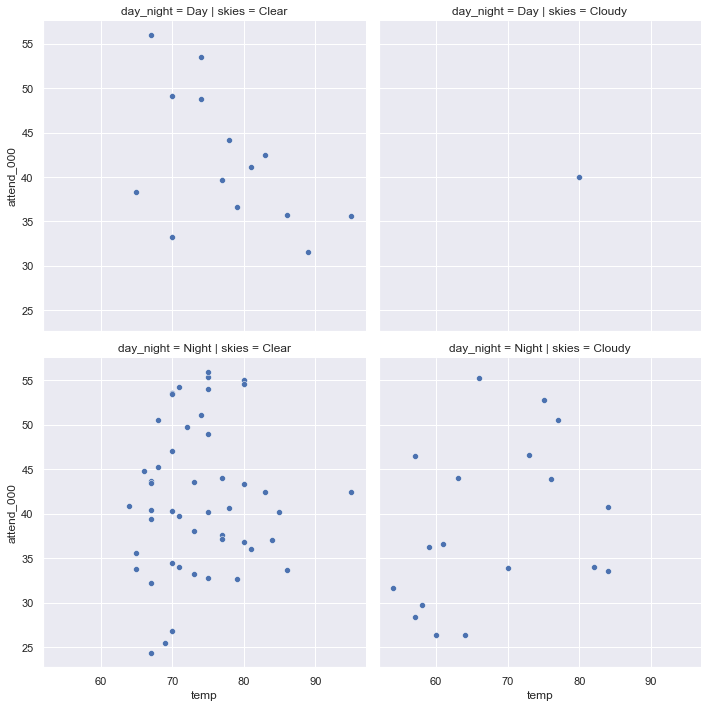

In [62]:
g = sns.FacetGrid(dodgers, row = 'day_night', col = 'skies', height=5, aspect=1)
g.map(sns.scatterplot, "temp", "attend_000")

We can see that a majority of attendance data lives within the clear night segment with a single datapoint existing on a cloudy day. There appears to be a coorelation between lower attendance and lower temperatures - especially on cloudy nights.

#### Opponent attendance analysis

<AxesSubplot:xlabel='attend_000', ylabel='opponent'>

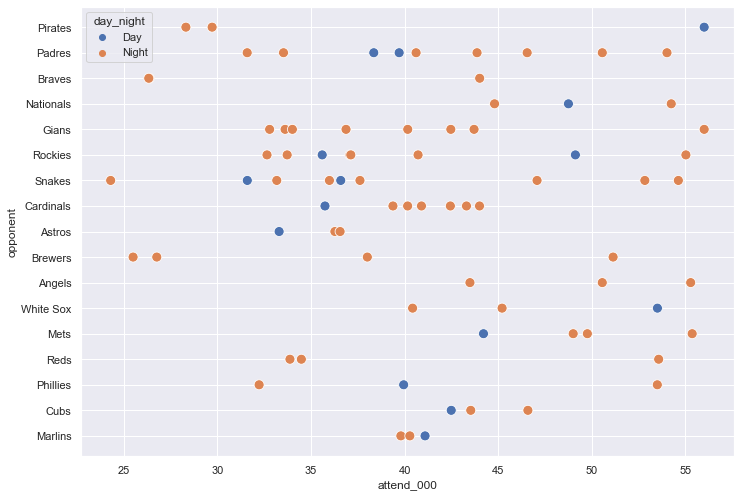

In [28]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(data=dodgers, x="attend_000", y="opponent", hue="day_night", s=100)

We can see the lowest attended games were against: Braves, Snakes, and Brewers. The Rockies, Pirates, Angels, and Mets all yielded great attendance!

### Regression model performance

In [30]:
# map day_of_week to ordered_day_of_week 
day_to_ordered_day = {'Monday' : '1Monday', 
     'Tuesday' : '2Tuesday', 
     'Wednesday' : '3Wednesday', 
     'Thursday' : '4Thursday', 
     'Friday' : '5Friday',
     'Saturday' : '6Saturday',
     'Sunday' : '7Sunday'}
dodgers['ordered_day_of_week'] = dodgers['day_of_week'].map(day_to_ordered_day)   

# map month to ordered_month
month_to_ordered_month = {'APR' : '1April', 
     'MAY' : '2May', 
     'JUN' : '3June', 
     'JUL' : '4July', 
     'AUG' : '5Aug',
     'SEP' : '6Sept',
     'OCT' : '7Oct'}
dodgers['ordered_month'] = dodgers['month'].map(month_to_ordered_month)    

# employ training-and-test regimen for model validation
np.random.seed(1234)
dodgers['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(dodgers))
dodgers_train = dodgers[dodgers['runiform'] >= 0.33]
dodgers_test = dodgers[dodgers['runiform'] < 0.33]
# check training data frame
print('\ndodgers_train data frame (rows, columns): ',dodgers_train.shape)
print(dodgers_train.head())
# check test data frame
print('\ndodgers_test data frame (rows, columns): ',dodgers_test.shape)
print(dodgers_test.head())

# specify a simple model with bobblehead entered last
my_model = str('attend ~ ordered_month + ordered_day_of_week + bobblehead')

# fit the model to the training set
train_model_fit = smf.ols(my_model, data = dodgers_train).fit()
# summary of model fit to the training set
print(train_model_fit.summary())
# training set predictions from the model fit to the training set
dodgers_train['predict_attend'] = train_model_fit.fittedvalues

# test set predictions from the model fit to the training set
dodgers_test['predict_attend'] = train_model_fit.predict(dodgers_test)

# compute the proportion of response variance
# accounted for when predicting out-of-sample
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(dodgers_test['attend'].corr(dodgers_test['predict_attend']),2),3))

# use the full data set to obtain an estimate of the increase in
# attendance due to bobbleheads, controlling for other factors 
my_model_fit = smf.ols(my_model, data = dodgers).fit()
print(my_model_fit.summary())

print('\nEstimated Effect of Bobblehead Promotion on Attendance: ',\
    round(my_model_fit.params[13],0))
    
# Suggestions for the student: Reproduce the figures in this chapter
# using matplotlib, ggplot, and/or rpy2 calls to R graphics. 
# Examine regression diagnostics for the fitted model.
# Examine other linear predictors and other explanatory variables.
# See if you can improve upon the model with variable transformations.   


dodgers_train data frame (rows, columns):  (57, 16)
  month  day  attend day_of_week opponent  temp   skies day_night cap shirt  \
1   APR   11   29729   Wednesday  Pirates    58  Cloudy     Night  NO    NO   
2   APR   12   28328    Thursday  Pirates    57  Cloudy     Night  NO    NO   
3   APR   13   31601      Friday   Padres    54  Cloudy     Night  NO    NO   
4   APR   14   46549    Saturday   Padres    57  Cloudy     Night  NO    NO   
7   APR   24   44014     Tuesday   Braves    63  Cloudy     Night  NO    NO   

  fireworks bobblehead  attend_000 ordered_day_of_week ordered_month  runiform  
1        NO         NO      29.729          3Wednesday        1April  0.622109  
2        NO         NO      28.328           4Thursday        1April  0.437728  
3       YES         NO      31.601             5Friday        1April  0.785359  
4        NO         NO      46.549           6Saturday        1April  0.779976  
7        NO         NO      44.014            2Tuesday        1Apri

C:\Users\graha\AppData\Local\Temp\ipykernel_18984\3406206324.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dodgers_train['predict_attend'] = train_model_fit.fittedvalues
C:\Users\graha\AppData\Local\Temp\ipykernel_18984\3406206324.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dodgers_test['predict_attend'] = train_model_fit.predict(dodgers_test)


In [41]:
print('\nProportion of Test Set Variance Accounted for: ',\
    round(np.power(dodgers_test['attend'].corr(dodgers_test['predict_attend']),2),3))


Proportion of Test Set Variance Accounted for:  0.176


<AxesSubplot:xlabel='attend', ylabel='predict_attend'>

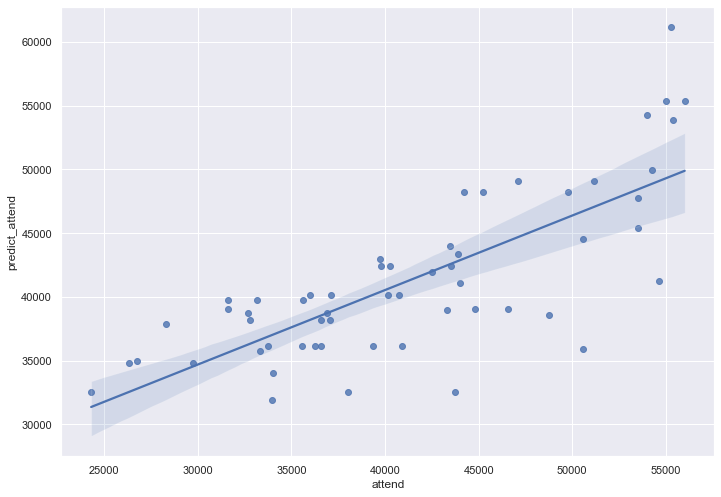

In [49]:
sns.regplot(data=dodgers_train, x="attend", y="predict_attend")

<AxesSubplot:xlabel='attend', ylabel='predict_attend'>

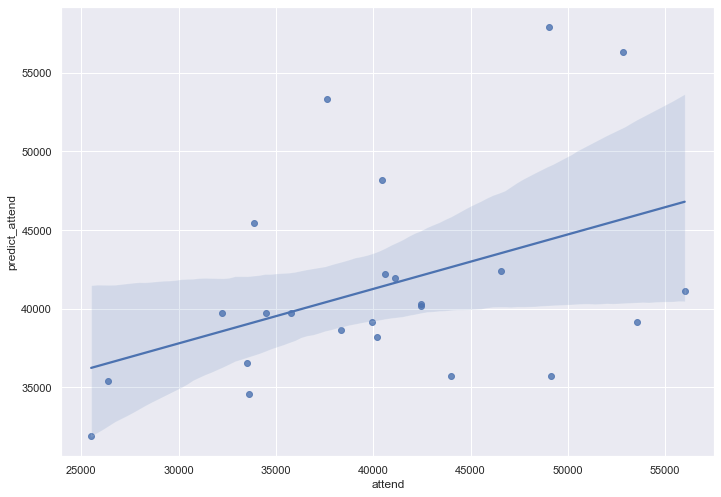

In [50]:
sns.regplot(data=dodgers_test, x="attend", y="predict_attend")

In [96]:
dodgers_train['source'] = "train"
dodgers_test['source'] = "test"
joined_test = pd.concat([dodgers_test, dodgers_train])
# joined_test

C:\Users\graha\AppData\Local\Temp\ipykernel_18984\1680184946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dodgers_train['source'] = "train"
C:\Users\graha\AppData\Local\Temp\ipykernel_18984\1680184946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dodgers_test['source'] = "test"


#### Visualizing performance - segmenting bobbleheads

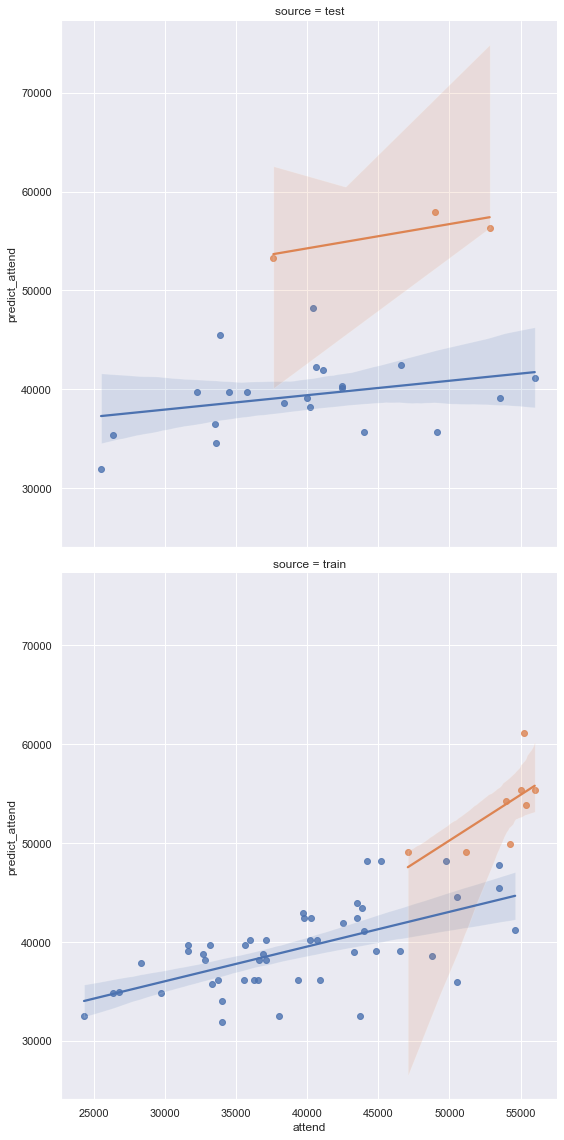

In [93]:
g = sns.FacetGrid(joined_test, row = 'source', height=8, aspect=1, hue="bobblehead")
g.map_dataframe(sns.regplot, x="attend", y="predict_attend")

#### Visualizing performance - including bobbleheads

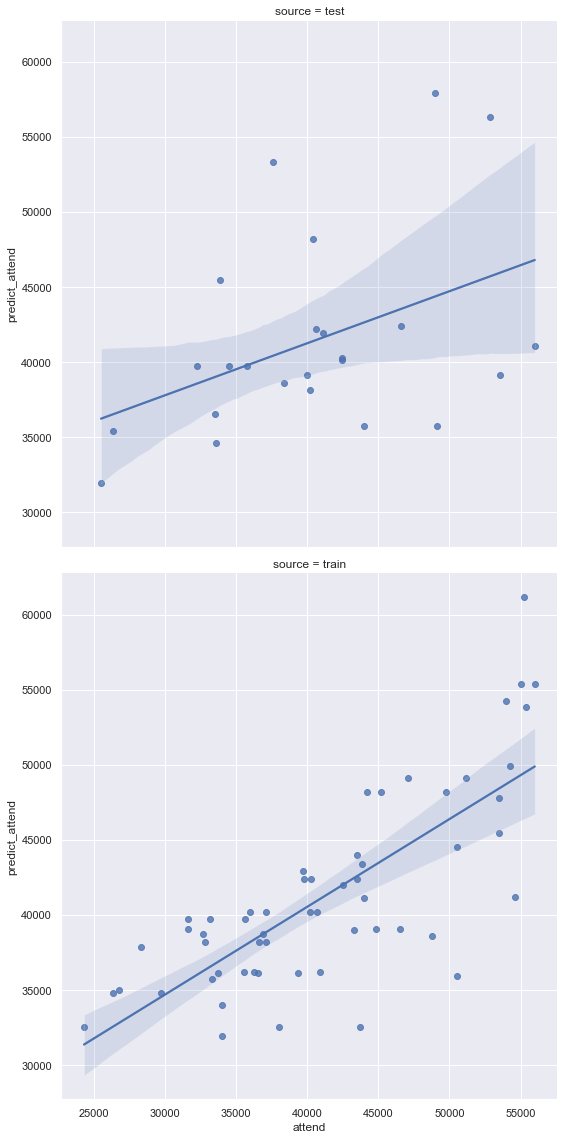

In [95]:
g = sns.FacetGrid(joined_test, row = 'source', height=8, aspect=1)
g.map_dataframe(sns.regplot, x="attend", y="predict_attend")

Given what our model produced and tested, then validated, we were only able to conclude a capture of ~18% total variability in the data. While that isn't bad, it can be improved upon. We can look into other factors, like time of year and which days may be more likely to sell. This can help us target our advertising and promote deals on slow sale days.